# Imports

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pprint
pp = pprint.PrettyPrinter(indent=4)

import acctrack.utils.ctd2021_data as data_helper
from acctrack.io.athena_raw_data import AthenaRawDataReader
from acctrack.tools.compare_tracking_algs import TrackAlgComparator


# Compare GNN with CKF

In [3]:
run_number = 242020
event_number = 24723
evtid = data_helper.find_event_index(event_number)


In [68]:
gnn_basedir = "/media/DataOcean/projects/tracking/integrateToAthena/run_21.9.26/RunOneEventForDebuging/GNN_noRemoval"
ckf_basedir = "/media/DataOcean/projects/tracking/integrateToAthena/run_21.9.26/RunOneEventForDebuging/CKF_noRemoval"

gnn_reader = AthenaRawDataReader(gnn_basedir, overwrite=False, name="GNN")
ckf_reader = AthenaRawDataReader(ckf_basedir, overwrite=False, name="CKF")


Total 1 events in directory: /media/DataOcean/projects/tracking/integrateToAthena/run_21.9.26/RunOneEventForDebuging/GNN_noRemoval
Total 1 events in directory: /media/DataOcean/projects/tracking/integrateToAthena/run_21.9.26/RunOneEventForDebuging/CKF_noRemoval


In [69]:
gnn_reader.read(event_number=event_number)
ckf_reader.read(event_number=event_number)

In [70]:
compare_gnn_ckf = TrackAlgComparator(gnn_reader, ckf_reader)

## Common tracks

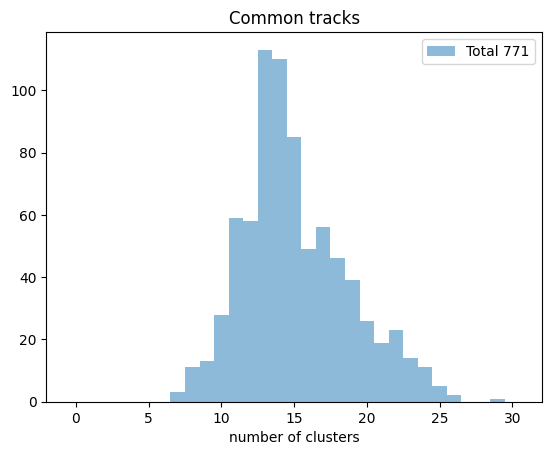

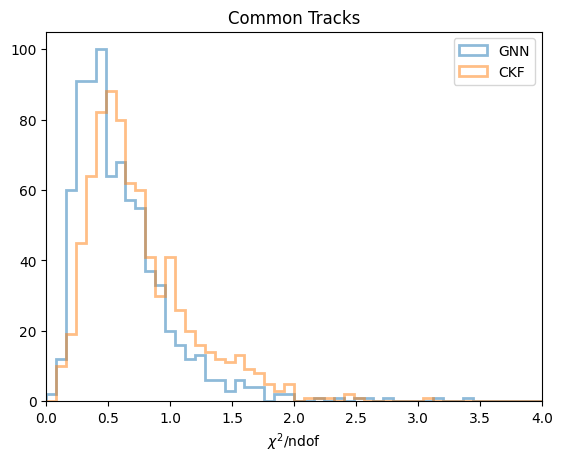

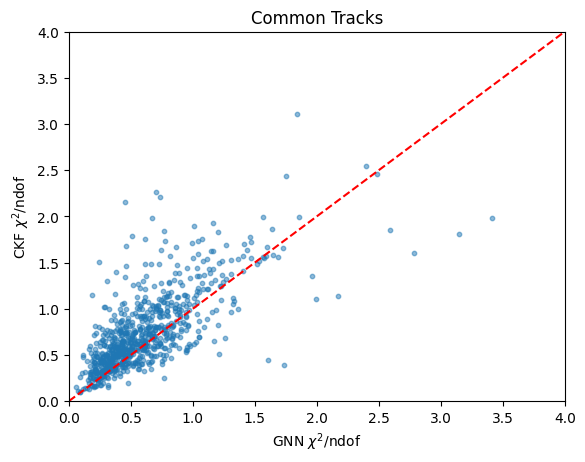

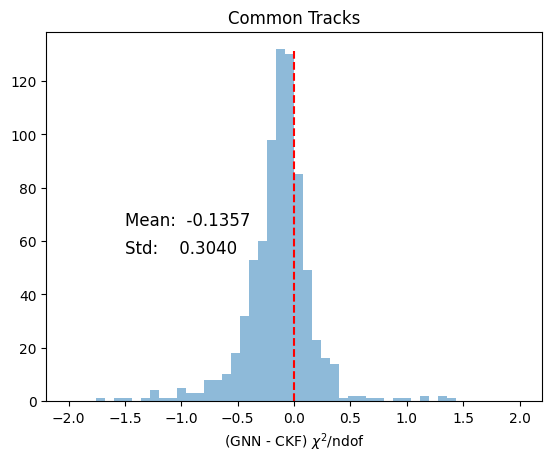

In [72]:
_ = compare_gnn_ckf.plot_common_tracks()

## Disjoint tracks

All matched to truth GNN:  1816 2422 0.749793559042114
All matched to truth CKF:  1876 2442 0.7682227682227682
2077 CKF tracks compared to 2012 GNN tracks.
Require min_num_clusters = 5 only for CKF tracks.
Total # of CKF tracks: 2077. After filtering, # of CKF tracks: 2077 (100.000%)
Matched: 771, 2077, 0.3712
CKF is a subset: 194, 2077, 0.0934
GNN is a subset: 449, 2077, 0.2162
Disjoint:  491, 2077, 0.2364


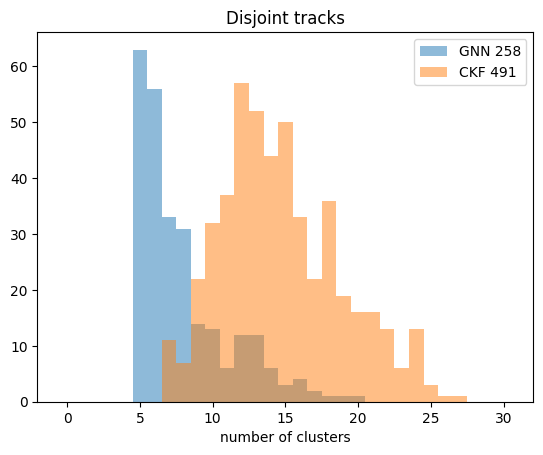

Number of good disjoint GNN tracks: 195 / 258
Number of good disjoint CKF tracks: 419 / 491


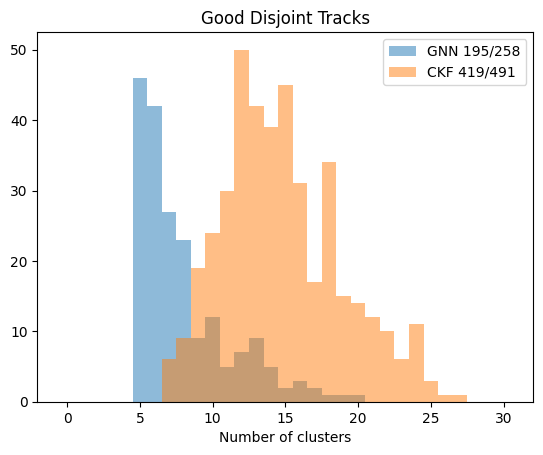

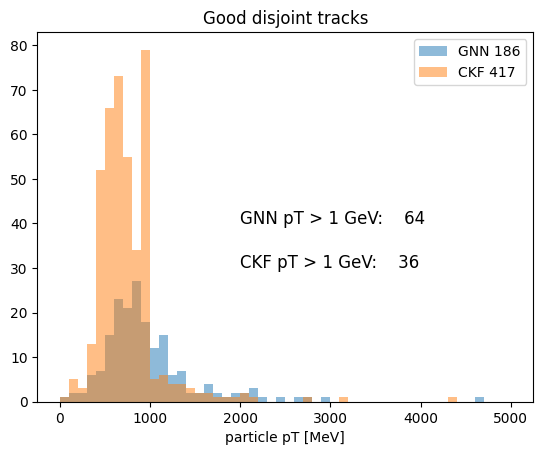

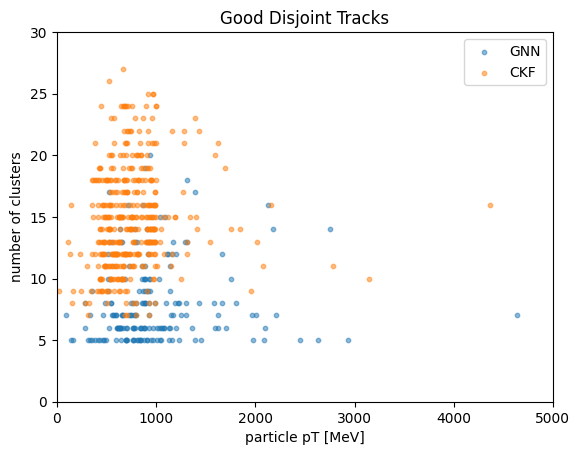

In [73]:
_ = compare_gnn_ckf.plot_disjoint_tracks()

# Basic Track Contents

Common tracks means the track contents are exactly the same.

In [6]:
num_gnn_tracks = len(gnn_reader.tracks_clusters)
num_ckf_tracks = len(ckf_reader.tracks_clusters)
print("num_gnn_tracks: ", num_gnn_tracks)
print("num_ckf_tracks: ", num_ckf_tracks)

num_gnn_tracks:  2012
num_ckf_tracks:  2077


In [7]:
min_num_clusters = 5
gnn_filtered = [x for x in gnn_reader.tracks_clusters if len(x) >= min_num_clusters]
ckf_filtered = [x for x in ckf_reader.tracks_clusters if len(x) >= min_num_clusters]

num_fil_gnn_tarcks = len(gnn_filtered)
num_fil_ckf_tracks = len(ckf_filtered)

print("filtered num_gnn_tracks: ", num_fil_gnn_tarcks)
print("filtered num_ckf_tracks: ", num_fil_ckf_tracks)

filtered num_gnn_tracks:  1821
filtered num_ckf_tracks:  2077


In [8]:
a = {1,2,3,4}
b = {1,2,3,5}
print(a == b)
print(a < b)
print(a > b)
print(a & b)
print(a - b)
print(a ^ b)
print(a.isdisjoint(b))

False
False
False
{1, 2, 3}
{4}
{4, 5}
False


* For each GNN track, find the closest CKF track that contains the same clusters. 
* Matched means the track contents are exactly the same. 
* That X is a subset means the track contents in X are a subset of the track contents in Y. 
* Disjoint means the track contents are disjoint (no common clusters). 

In [9]:
def compare_tracks(track_reader, other_track_reader, min_num_clusters=5):
    """tracks compared to other_tracks"""
    label= track_reader.name
    other_label = other_track_reader.name
    tracks = track_reader.tracks_clusters
    other_tracks = other_track_reader.tracks_clusters

    print(f"{label} compared to {other_label}.\nApply min_num_clusters={min_num_clusters} filter on {label} tracks.")
    num_matched = 0
    num_issubset = 0
    num_other_issubset = 0
    num_disjoints = 0

    unmatched_tracks = []
    disjoint_tracks = []
    common_tracks = []

    tot_tracks = len(tracks)

    tot_filtered_tracks = 0
    for trkid,track in enumerate(tracks):
        if len(track) < min_num_clusters:
            continue
        tot_filtered_tracks += 1
        found_a_match = False
        all_disjoint = True
        found_as_subset = False
        found_other_as_subset = False
        ckf_idx = -1

        for idx,other_track in enumerate(other_tracks):
            track_set = set(track)
            other_track_set = set(other_track)
            if not track_set.isdisjoint(other_track_set):
                all_disjoint = False
            if track_set == other_track_set:
                found_a_match = True
                ckf_idx = idx
            if track_set < other_track_set:
                found_as_subset = True
            if track_set > other_track_set:
                found_other_as_subset = True

        if found_a_match:
            num_matched += 1
            common_tracks.append((trkid,track,ckf_idx))
        else:
            unmatched_tracks.append((trkid,track))
        
        if all_disjoint:
            num_disjoints += 1
            disjoint_tracks.append((trkid,track))
        if found_as_subset:
            num_issubset += 1
        if found_other_as_subset:
            num_other_issubset += 1

    print(f"Summary for {label} Tracks")
    print(f"Total # of {label} tracks: {tot_tracks}. After filtering, # of {label} tracks: {tot_filtered_tracks} ({tot_filtered_tracks/tot_tracks*100:.3f}%)")
    print(f"Matched: {num_matched}, {tot_filtered_tracks}, {num_matched/tot_filtered_tracks:.4f}")
    print(f"{label} is a subset: {num_issubset}, {tot_filtered_tracks}, {num_issubset/tot_filtered_tracks:.4f}")
    print(f"{other_label} is a subset: {num_other_issubset}, {tot_filtered_tracks}, {num_other_issubset/tot_filtered_tracks:.4f}")
    print(f"Disjoint:  {num_disjoints}, {tot_filtered_tracks}, {num_disjoints/tot_filtered_tracks:.4f}")
    return common_tracks, unmatched_tracks, disjoint_tracks

In [10]:
1821./2012

0.9050695825049702

In [11]:
common_fil_gnn_tracks, unmatched_fil_gnn_tracks, disjoint_fil_gnn_tracks = compare_tracks(gnn_reader, ckf_reader, min_num_clusters=5)

GNN compared to CKF.
Apply min_num_clusters=5 filter on GNN tracks.
Summary for GNN Tracks
Total # of GNN tracks: 2012. After filtering, # of GNN tracks: 1821 (90.507%)
Matched: 771, 1821, 0.4234
GNN is a subset: 428, 1821, 0.2350
CKF is a subset: 194, 1821, 0.1065
Disjoint:  258, 1821, 0.1417


In [12]:
len(unmatched_fil_gnn_tracks), len(common_fil_gnn_tracks)

(1050, 771)

In [13]:
_ = compare_tracks(gnn_reader, ckf_reader, min_num_clusters=0)

GNN compared to CKF.
Apply min_num_clusters=0 filter on GNN tracks.
Summary for GNN Tracks
Total # of GNN tracks: 2012. After filtering, # of GNN tracks: 2012 (100.000%)
Matched: 771, 2012, 0.3832
GNN is a subset: 466, 2012, 0.2316
CKF is a subset: 194, 2012, 0.0964
Disjoint:  407, 2012, 0.2023


In [14]:
common_fil_ckf_tracks, unmatched_fil_ckf_tracks, disjoint_fil_ckf_tracks = compare_tracks(ckf_reader, gnn_reader, min_num_clusters=5)

CKF compared to GNN.
Apply min_num_clusters=5 filter on CKF tracks.
Summary for CKF Tracks
Total # of CKF tracks: 2077. After filtering, # of CKF tracks: 2077 (100.000%)
Matched: 771, 2077, 0.3712
CKF is a subset: 194, 2077, 0.0934
GNN is a subset: 449, 2077, 0.2162
Disjoint:  491, 2077, 0.2364


## True Tracks
This section is to label a track if it is a good track. A track is good if all of its contents are matched to a truth track.

In [15]:
gnn_reader.true_tracks

,trkid,fitter,material,nDoF,chi2,charge,x,y,z,px,...,pz,mot,oot,subevent,barcode,probability,pdgId,status,particle_id,pt
0,0,5,3,1,1.209240,1,21.709999,-17.220400,85.783600,408.217987,...,2342.620117,6,0,5602,200119,1.0,-11,1,56020200119,656.889221
1,1,5,3,1,0.294469,-1,3.704400,4.959140,-72.096703,406.812012,...,4612.330078,3,0,5514,503,1.0,-211,1,55140000503,507.779755
2,2,5,3,3,0.577462,1,-0.424177,0.057936,37.298401,-94.805702,...,11525.400391,4,0,5586,280,1.0,321,1,55860000280,700.563599
3,3,5,3,5,11.910700,1,-15.425600,3.763470,-80.836601,-428.201996,...,19021.699219,5,0,5543,200074,0.8,11,1,55430200074,1806.590210
4,4,5,3,3,0.068077,1,-8.576700,6.303310,-46.327999,-246.557999,...,7730.319824,4,0,5512,404,1.0,-211,1,55120000404,416.340820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007,2007,5,3,35,38.334301,1,-0.245878,0.030624,-80.116699,-117.470001,...,-16419.800781,20,0,5529,1591,1.0,321,1,55290001591,950.448242
2008,2008,5,3,13,2.493920,-1,-0.059898,0.046971,20.617800,-1760.459961,...,-39237.300781,9,0,5655,1668,1.0,-211,1,56550001668,2852.936035
2009,2009,5,3,23,12.198000,-1,0.012162,-0.028895,-24.950100,-1505.859985,...,-27041.400391,14,0,5621,553,1.0,-321,1,56210000553,1633.819092
2010,2010,5,3,21,5.600050,-1,0.020114,-0.034423,22.863100,-1032.369995,...,-15135.599609,13,0,5630,1283,1.0,-321,1,56300001283,1195.697388


In [16]:
def match_to_truth(reader):
    detailed = reader.detailed_matching
    all_matched_to_truth = detailed[ 
    (detailed.reco_pixel_hits == detailed.common_pixel_hits) \
    & (detailed.reco_sct_hits == detailed.common_sct_hits) ]
    num_all_matched_to_truth = len(all_matched_to_truth)

    frac_all_matched_to_truth = num_all_matched_to_truth / len(detailed)
    print(f"All matched to truth {reader.name}: ", num_all_matched_to_truth, len(detailed), frac_all_matched_to_truth)
    return all_matched_to_truth

In [17]:
gnn_tracks_matched_to_truth = match_to_truth(gnn_reader)
ckf_tracks_matched_to_truth = match_to_truth(ckf_reader)

All matched to truth GNN:  1816 2422 0.749793559042114
All matched to truth CKF:  1876 2442 0.7682227682227682


In [18]:
gnn_reader.detailed_matching['num_matched'].value_counts()

1    2171
2     232
3      18
4       1
Name: num_matched, dtype: int64

In [19]:
ckf_reader.detailed_matching['num_matched'].value_counts()

1    2215
2     204
3      20
4       2
7       1
Name: num_matched, dtype: int64

# Disjoint Tracks

Disjoint tracks are the tracks that are found only by one algorithm but not the other. 
A good disjoint track is a disjoint track whose contents are all matched to a truth track.

Text(0.5, 0, 'number of clusters')

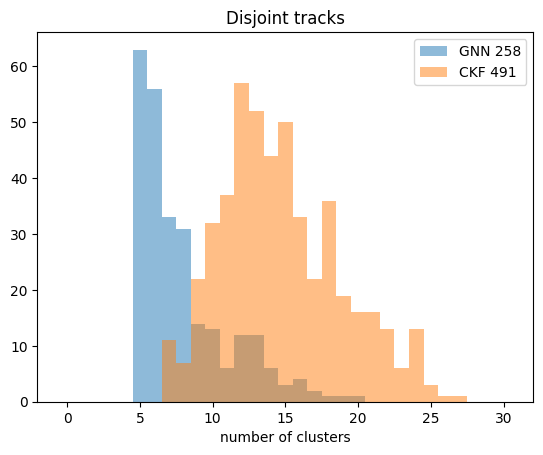

In [20]:
num_gnn_disjoints = len(disjoint_fil_gnn_tracks)
num_ckf_disjoints = len(disjoint_fil_ckf_tracks)

plt.title("Disjoint tracks")
plt.hist([len(x[1]) for x in disjoint_fil_gnn_tracks], bins=31, range=(-0.5,30.5),
         label=f"GNN {num_gnn_disjoints}", alpha=0.5)
plt.hist([len(x[1]) for x in disjoint_fil_ckf_tracks], bins=31, range=(-0.5,30.5), 
         label=f"CKF {num_ckf_disjoints}", alpha=0.5)
plt.legend()
plt.xlabel("number of clusters")

In [21]:
# GNN disjoint tracks
disjoint_gnn_track_idx = np.array([x[0] for x in disjoint_fil_gnn_tracks], dtype=int)
gnn_good_disjoints = gnn_tracks_matched_to_truth[gnn_tracks_matched_to_truth.trkid.isin(disjoint_gnn_track_idx)]
num_gnn_good_disjoints = len(gnn_good_disjoints)

# CKF disjoint tracks
disjoint_ckf_track_idx = np.array([x[0] for x in disjoint_fil_ckf_tracks], dtype=int)
ckf_good_disjoints = ckf_tracks_matched_to_truth[ckf_tracks_matched_to_truth.trkid.isin(disjoint_ckf_track_idx)]
num_ckf_good_disjoints = len(ckf_good_disjoints)

print("Number of good disjoint GNN tracks: ", num_gnn_good_disjoints)
print("Number of good disjoint CKF tracks: ", num_ckf_good_disjoints)

Number of good disjoint GNN tracks:  195
Number of good disjoint CKF tracks:  419


## Characteristics of Good Disjoint Tracks
OK. It seems both GNN and CKF are finding some good trackings that are not found by the other. 
Let's characterize these tracks.
* number of clusters
* pT of the matched track
* number of clusters vs pT

Text(0.5, 0, 'Number of clusters')

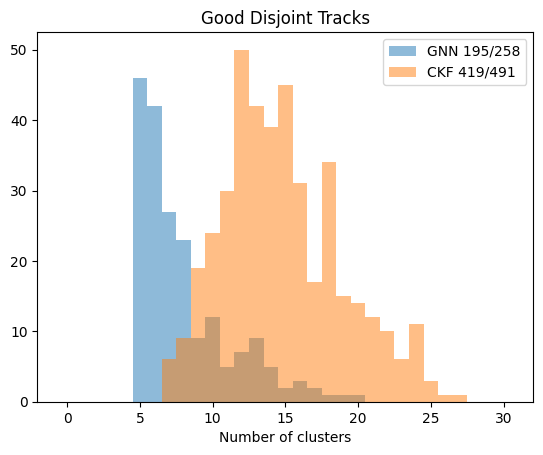

In [22]:
gnn_good_disjoints_tot_hits = gnn_good_disjoints.reco_pixel_hits + gnn_good_disjoints.reco_sct_hits
ckf_good_disjoints_tot_hits = ckf_good_disjoints.reco_pixel_hits + ckf_good_disjoints.reco_sct_hits

plt.title("Good Disjoint Tracks")
plt.hist(gnn_good_disjoints_tot_hits, bins=31, range=(-0.5,30.5),
            label=f"GNN {num_gnn_good_disjoints}/{num_gnn_disjoints}", alpha=0.5)
plt.hist(ckf_good_disjoints_tot_hits, bins=31, range=(-0.5,30.5),
            label=f"CKF {num_ckf_good_disjoints}/{num_ckf_disjoints}", alpha=0.5)
plt.legend()
plt.xlabel("Number of clusters")


In [23]:
print(186/195)
print(417/419)

0.9538461538461539
0.9952267303102625


In [24]:
particles = gnn_reader.particles

gnn_good_disjoints_matched_particles = particles[particles.particle_id.isin(gnn_good_disjoints.particle_id.values)]
ckf_good_disjoints_matched_particles = particles[particles.particle_id.isin(ckf_good_disjoints.particle_id.values)]


Text(0.5, 0, 'particle pT [MeV]')

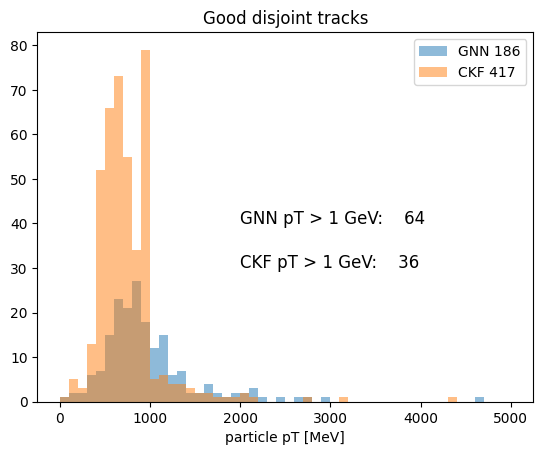

In [25]:
pt_gnn = gnn_good_disjoints_matched_particles.pt
pt_ckf = ckf_good_disjoints_matched_particles.pt
num_high_pt_gnn = len(pt_gnn[pt_gnn > 1000])
num_high_pt_ckf = len(pt_ckf[pt_ckf > 1000])

plt.title("Good disjoint tracks")
plt.hist(pt_gnn, bins=50, range=(0,5000), label=f"GNN {len(pt_gnn)}", alpha=0.5)
plt.text(2000, 40, f"GNN pT > 1 GeV: {num_high_pt_gnn:5}", fontsize=12)
plt.text(2000, 30, f"CKF pT > 1 GeV: {num_high_pt_ckf:5}", fontsize=12)
plt.hist(pt_ckf, bins=50, range=(0,5000), label=f"CKF {len(pt_ckf)}", alpha=0.5)
plt.legend()
plt.xlabel("particle pT [MeV]")

In [26]:
merged_gnn = gnn_good_disjoints_matched_particles.merge(gnn_good_disjoints, on='particle_id')
merged_ckf = ckf_good_disjoints_matched_particles.merge(ckf_good_disjoints, on='particle_id')

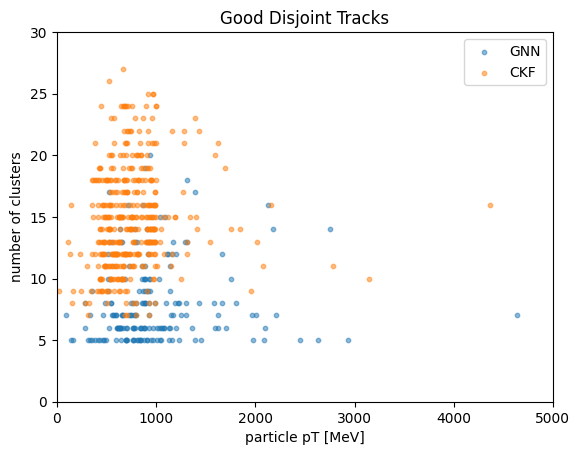

In [27]:
plt.title("Good Disjoint Tracks")
config = dict(s=10.0, alpha=0.5)
plt.scatter(merged_gnn.pt, 
            merged_gnn.reco_pixel_hits + merged_gnn.reco_sct_hits, label="GNN", **config)
plt.scatter(merged_ckf.pt,
            merged_ckf.reco_pixel_hits + merged_ckf.reco_sct_hits, label="CKF", **config)
plt.xlim(0, 5000)
plt.ylim(0, 30)
plt.xlabel("particle pT [MeV]")
plt.ylabel("number of clusters")
plt.legend()

## Good Disjoint Tracks from CKF with pT > 1 GeV
There are 36 tracks only found by CKF and matched to true particles with pT > 1 GeV. However, the track contents of those tracks are not used at all by GNN. Let's look at the details of these tracks. 

In [28]:
ckf_matched_pids = ckf_good_disjoints_matched_particles[pt_ckf > 1000].particle_id.values
ckf_disjoints_good_match = ckf_good_disjoints[ckf_good_disjoints.particle_id.isin(ckf_matched_pids)]

good_ckf_only_clusters = [ckf_reader.tracks_clusters[x] for x in ckf_disjoints_good_match.trkid.values]
good_ckf_only_clusters = np.array([item for sublist in good_ckf_only_clusters for item in sublist], dtype=int)
good_ckf_only_cluster_info = ckf_reader.clusters[ckf_reader.clusters.cluster_id.isin(good_ckf_only_clusters)]
good_ckf_only_cluster_info = good_ckf_only_cluster_info.assign(
    cluster_r=np.sqrt(good_ckf_only_cluster_info.cluster_x**2 + good_ckf_only_cluster_info.cluster_y**2))


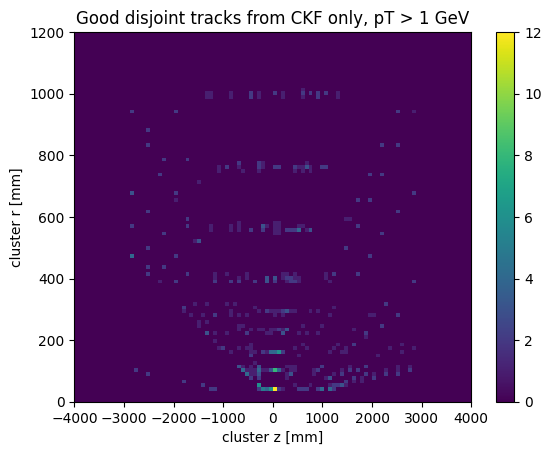

In [29]:
plt.title("Good disjoint tracks from CKF only, pT > 1 GeV")
plt.hist2d(good_ckf_only_cluster_info.cluster_z, good_ckf_only_cluster_info.cluster_r, bins=100, range=((-4000, 4000), (0, 1200)))
plt.xlabel("cluster z [mm]")
plt.ylabel("cluster r [mm]")
plt.colorbar()


# Common Tracks
There are 771 common tracks between GNN and CKF. Let's look at the details of these tracks.

In [30]:
compare_CKF_GNN = TrackAlgComparator(gnn_reader, ckf_reader, name="GNN vs CKF")

2012 GNN tracks compared to 2077 CKF tracks.
Require min_num_clusters = 5 only for GNN tracks.
Total # of GNN tracks: 2012. After filtering, # of GNN tracks: 1821 (90.507%)
Matched: 771, 1821, 0.4234
GNN is a subset: 428, 1821, 0.2350
CKF is a subset: 194, 1821, 0.1065
Disjoint:  258, 1821, 0.1417


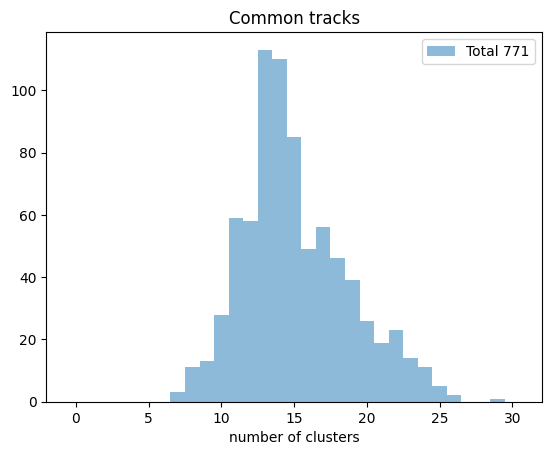

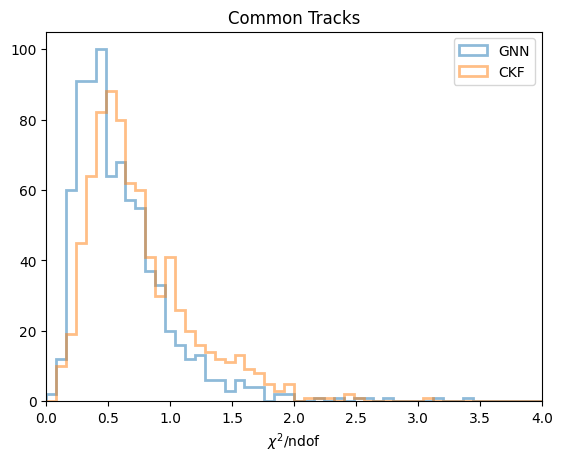

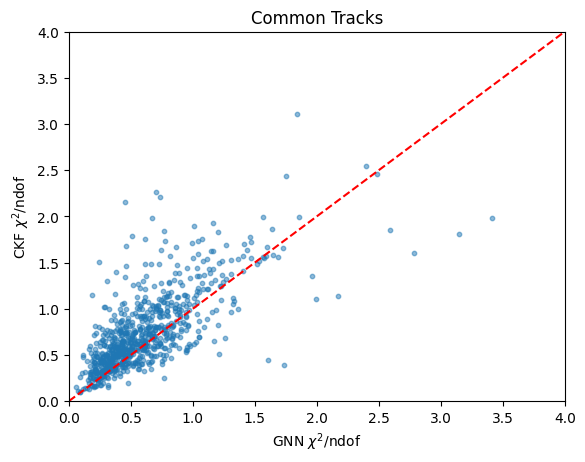

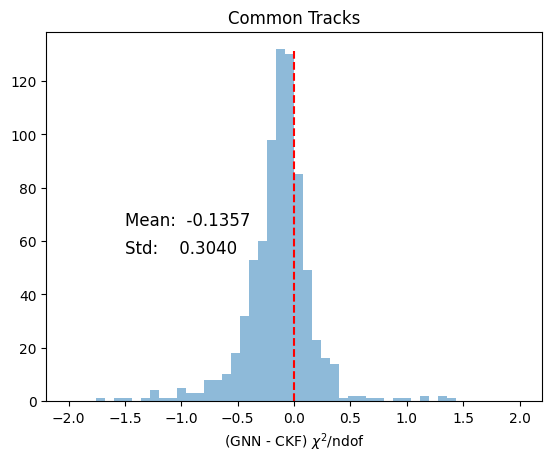

In [31]:
gnn_chi2, ckf_chi2 = compare_CKF_GNN.plot_common_tracks()

In [32]:
print(compare_CKF_GNN.common_track_indices[0])
print(compare_CKF_GNN.common_track_indices[4])
print("{:.6f}, {:.6f}".format(gnn_chi2[0], ckf_chi2[0]))
print("{:.6f}, {:.6f}".format(gnn_chi2[4], ckf_chi2[4]))

(13, [170007, 170083, 170153, 170229, 206124, 206293, 206160, 206332, 206201, 204650, 204743, 204843, 204945], 829)
(17, [168996, 169943, 169073, 170029, 169133, 170099, 170165, 206098, 206139, 206176, 204437, 202819, 204579, 204669, 204768, 204868], 251)
0.458252, 0.405440
0.396159, 0.490726


In [33]:
with open("common_tracks.txt", "w") as f:
    for gnn_common_trkid, gnn_common_clusters, ckf_common_trkid in compare_CKF_GNN.common_track_indices:
        output = ",".join([str(x) for x in gnn_common_clusters])
        output += "\n"
        f.write(output)

## Sanity Check of Common Tracks

Use the GNN setup to fit those common tracks to make sure the fitted $\chi^2$ is the same as the one from GNN or CKF.

Yes, the fitted $\chi^2$ is the same as the one obtained from the GNN setup. Note that, in this case, the inputs are clusters.

In [34]:
common_base_dir = "/media/DataOcean/projects/tracking/integrateToAthena/run_21.9.26/RunOneEventForDebuging/Common_noRemoval"
common_reader = AthenaRawDataReader(common_base_dir, overwrite=False, name="Common")
common_reader.read(event_number=event_number)

Total 1 events in directory: /media/DataOcean/projects/tracking/integrateToAthena/run_21.9.26/RunOneEventForDebuging/Common_noRemoval


In [35]:
common_chi2 = common_reader.true_tracks.chi2 / common_reader.true_tracks.nDoF

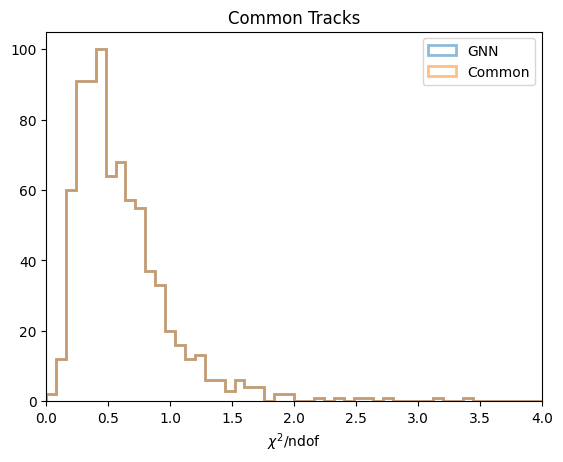

In [36]:
plt.title("Common Tracks")
chi2_hist_config = dict(bins=50, range=(0, 4), alpha=0.5, histtype='step', lw=2)
plt.hist(gnn_chi2, **chi2_hist_config, label="GNN")
plt.hist(common_chi2, **chi2_hist_config, label="Common")
plt.xlim(0, 4)
plt.xlabel("$\chi^2$/ndof")
plt.legend()

# Detailed Comparison of Two Common Tracks

Turn on the debug level printout for the Global $\chi^2$ Fitter and look into the fitting results for the common tracks.

In [37]:
gxf_debug_ckf_fname = "/media/DataOcean/projects/tracking/integrateToAthena/run_21.9.26/RunOneEventForDebuging/TwoCommonEventsDebug/CKF/log.txt"
gxf_debug_gnn_fname = "/media/DataOcean/projects/tracking/integrateToAthena/run_21.9.26/RunOneEventForDebuging/TwoCommonEventsDebug/GNN/log.txt"
gnn_trkids = [0, 1]
ckf_trkids = [0] + [common_fil_gnn_tracks[x][2] for x in [0, 4]]
ckf_trkids

[0, 829, 251]

In [38]:
def extract_fitting_info(fname, trkids):
    """Get the printout of the Global Fitter for all track ids.
    Assume there is one event. 
    """
    output = dict((x, []) for x in trkids)
    prefix = "ToolSvc.InDetTrackFitter                  DEBUG "
    start_line = prefix + "--> entering GlobalChi2Fitter::fit(Meas'BaseSet,,)"
    with open(fname, "r") as f:
        do_start_save = False
        this_trk_id = -1

        start_count_down = False
        count_down = 0
        max_addition = 11
        for line in f.readlines():
            if line.startswith(start_line):
                this_trk_id += 1
                if this_trk_id in trkids:
                    do_start_save = True
                else:
                    do_start_save = False
                continue
                    
            if do_start_save:
                line = line.replace(prefix, "")
                output[this_trk_id].append(line)
                if "Final perigee:  * TrackParameters on Surface" in line:
                    start_count_down = True
                if start_count_down:
                    count_down += 1
                    if count_down > max_addition:
                        do_start_save = False
                        start_count_down = False
                        count_down = 0
    print(f"Found {this_trk_id+1} tracks in {fname}")
    return output

In [39]:
gnn_info = extract_fitting_info(gxf_debug_gnn_fname, gnn_trkids)
ckf_info = extract_fitting_info(gxf_debug_ckf_fname, ckf_trkids)

Found 2 tracks in /media/DataOcean/projects/tracking/integrateToAthena/run_21.9.26/RunOneEventForDebuging/TwoCommonEventsDebug/GNN/log.txt
Found 2634 tracks in /media/DataOcean/projects/tracking/integrateToAthena/run_21.9.26/RunOneEventForDebuging/TwoCommonEventsDebug/CKF/log.txt


In [40]:
np.unique(np.random.randint(0, 100, size=50)).shape

(41,)

The Global chi2 fitter fitted 2634 CKF tracks but only 2077 of them are accepted. The track indices are completely messed up. Fortunately, the first track is accepted. We could look at that one to see if the input cluster positions are the same. The answer is that they are not exactly the same. 

In [41]:
print(gnn_info[0])

['#0 Pixel hit pos=(36.0077,-13.0403,902) \n', '#1 Pixel hit pos=(40.2732,-14.6365,1010) \n', '#2 Pixel hit pos=(44.7882,-16.3664,1125) \n', '#3 Pixel hit pos=(49.9146,-18.2949,1255) \n', '#4 Pixel hit pos=(58.8138,-21.7469,1482) \n', '#5 Pixel hit pos=(58.9544,-21.79,1486) \n', '#6 Pixel hit pos=(64.9895,-24.1343,1639) \n', '#7 Pixel hit pos=(65.1288,-24.1737,1643) \n', '#8 Pixel hit pos=(71.0157,-26.4864,1793) \n', '#9 Pixel hit pos=(82.0925,-30.9057,2076) \n', '#10 Pixel hit pos=(89.8077,-34.0203,2274) \n', '#11 Pixel hit pos=(98.2701,-37.4239,2491) \n', '#12 Pixel hit pos=(107.632,-41.202,2732) \n', 'start param:  * TrackParameters on Surface\n', ' * loc1  : -1.2750299\n', ' * loc2  : -7.8750000\n', ' * phi   : -0.3621234\n', ' * Theta : 0.0420639\n', ' * q/p   : 0.0000421\n', ' * corresponding global parameters:\n', ' *    position  (x,  y,  z ) = (36.0076822, -13.0402510, 902.0000000)\n', ' *    momentum  (px, py, pz) = (935.1467115, -354.2606779, 23759.3106586)\n', ' pos:  36.00

In [42]:
print(ckf_trkids[1], ckf_info[ckf_trkids[1]])

829 ['#0 Pixel hit pos=(36.025703,14.962119,212.110500) \n', '#1 Pixel hit pos=(45.564456,19.299781,263.000000) \n', '#2 Pixel hit pos=(49.866576,21.275928,286.000000) \n', '#3 Pixel hit pos=(75.469950,33.327657,423.000000) \n', '#4 Pixel hit pos=(83.430532,37.223258,466.000000) \n', '#5 Pixel hit pos=(84.182920,37.578145,470.000000) \n', '#6 Pixel hit pos=(94.372428,42.623828,525.000000) \n', '#7 Pixel hit pos=(105.267266,48.161552,584.000000) \n', '#8 Pixel hit pos=(153.681877,73.853398,847.460103) \n', '#9 Pixel hit pos=(206.869258,104.835172,1142.997500) \n', '#10 Pixel hit pos=(255.232222,135.678819,1419.002500) \n', '#11 SCT endcap hit pos=(348.341966,201.615774,1956.251000) \n', '#12 SCT endcap hit pos=(348.239710,201.792378,1962.749000) \n', '#13 SCT endcap hit pos=(417.775522,251.087369,2241.251000) \n', '#14 SCT endcap hit pos=(417.179637,252.076243,2247.749000) \n', '#15 SCT endcap hit pos=(453.296931,282.289923,2536.251000) \n', '#16 SCT endcap hit pos=(452.943254,282.85713

In [43]:
print(ckf_info[0])

['#0 Pixel hit pos=(36.625,-6.575,-259) \n', '#1 Pixel hit pos=(37.2174,-6.65135,-263) \n', '#2 Pixel hit pos=(40.075,-7.125,-282) \n', '#3 Pixel hit pos=(40.6637,-7.2149,-286) \n', '#4 Pixel hit pos=(44.425,-7.825,-311) \n', '#5 Pixel hit pos=(45.0291,-7.92776,-315) \n', '#6 Pixel hit pos=(49.0537,-8.525,-342) \n', '#7 Pixel hit pos=(49.6663,-8.61584,-346) \n', '#8 Pixel hit pos=(54.5964,-9.35357,-379) \n', '#9 Pixel hit pos=(55.2076,-9.44749,-383) \n', '#10 Pixel hit pos=(84.775,-13.375,-580) \n', '#11 Pixel hit pos=(85.4068,-13.4242,-584) \n', '#12 Pixel hit pos=(95.025,-14.525,-648) \n', '#13 Pixel hit pos=(95.6238,-14.5884,-652) \n', '#14 Pixel hit pos=(105.903,-15.675,-720) \n', '#15 Pixel hit pos=(106.51,-15.7072,-724) \n', '#16 Pixel hit pos=(118.525,-16.9039,-803) \n', '#17 Pixel hit pos=(154.989,-19.1853,-1040.31) \n', '#18 Pixel hit pos=(156.273,-19.2606,-1048.62) \n', '#19 Pixel hit pos=(172.314,-19.8446,-1153) \n', '#20 Pixel hit pos=(188.224,-20.3366,-1257) \n', '#21 Pixe

In [44]:
ckf_reader.true_tracks.iloc[0]

trkid                    0
fitter                   5
material                 3
nDoF                    47
chi2               27.0485
charge                  -1
x                 0.033928
y                 0.166654
z                 -13.3596
px              578.323975
py             -117.737999
pz            -3895.590088
mot                     27
oot                      0
subevent              5564
barcode                420
probability            1.0
pdgId                 -211
status                   1
particle_id    55640000420
pt              590.187134
Name: 0, dtype: object

In [45]:
# `isin` does not preserve the order of the elements in the array. 
ckf_clusters = ckf_reader.clusters
ckf_clusters.set_index("cluster_id").loc[ckf_reader.tracks[0]].reset_index()

,cluster_id,hardware,cluster_x,cluster_y,cluster_z,barrel_endcap,layer_disk,eta_module,phi_module,side,...,ly,lz,geta,gphi,eta_angle,phi_angle,norm_x,norm_y,norm_z,particle_id
0,8916,PIXEL,36.625000,-6.575000,-259.000000,-2,0,0,9,0,...,0.050000,0.15,1.496610,0.785398,1.249050,1.249050,0,0,-1,55640000420
1,7832,PIXEL,37.216202,-6.650970,-263.000000,-2,0,0,8,0,...,0.050000,0.15,1.103590,0.792989,1.249050,0.982794,0,0,-1,55640000420
2,8980,PIXEL,40.075001,-7.125000,-282.000000,-2,0,1,9,0,...,0.050000,0.15,1.496610,0.785398,1.249050,1.249050,0,0,-1,55640000420
3,7906,PIXEL,40.670101,-7.212420,-286.000000,-2,0,1,8,0,...,0.100000,0.15,0.923623,0.471239,0.982794,0.982794,0,0,-1,55640000420
4,9044,PIXEL,44.424999,-7.825000,-311.000000,-2,0,2,9,0,...,0.050000,0.15,1.496610,0.785398,1.249050,1.249050,0,0,-1,55640000420
5,7985,PIXEL,45.029099,-7.927760,-315.000000,-2,0,2,8,0,...,0.050000,0.15,1.496610,0.471239,1.249050,1.249050,0,0,-1,55640000420
6,9102,PIXEL,49.049999,-8.525000,-342.000000,-2,0,3,9,0,...,0.050000,0.15,1.103590,1.107150,1.249050,0.982794,0,0,-1,55640000420
7,8074,PIXEL,49.667198,-8.619890,-346.000000,-2,0,3,8,0,...,0.100000,0.15,0.923623,0.471239,0.982794,0.982794,0,0,-1,55640000420
8,9156,PIXEL,54.591702,-9.358330,-379.000000,-2,0,4,9,0,...,0.100000,0.15,0.923623,0.785398,0.982794,0.982794,0,0,-1,55640000420
9,8141,PIXEL,55.207600,-9.447490,-383.000000,-2,0,4,8,0,...,0.050000,0.15,1.496610,0.471239,1.249050,1.249050,0,0,-1,55640000420


In [46]:
print("{:.6f}, {:.6f}".format(gnn_chi2[0], ckf_chi2[0]))
df

0.458252, 0.405440


NameError: name 'df' is not defined

# Ambiguity Processor

The AmbiguityProcessor is used to resolve the ambiguity tracks for the CKF. It can *ForceRefit* and *RefitPrds*. *ForceRefit* means the track candidates are refitted even if they are not ambiguous. *RefitPrds* means the track candidates are refitted using the PRD positions instead of the original position.

Changing the two options also changes the number of accepted tracks.

## Impact on CKF Tracks

In [ ]:
def get_ckf_chi2(reader):
    return np.array([reader.true_tracks.iloc[x[2]].chi2 / reader.true_tracks.iloc[x[2]].nDoF
                     for x in common_fil_gnn_tracks])

Without refitting the prepared raw data. 

In [ ]:
ckf_noRefitPrds_base_dir = "/media/DataOcean/projects/tracking/integrateToAthena/run_21.9.26/RunOneEventForDebuging/CKF_noRemoval_noReFitPrds"
ckf_noRefitPrds_reader = AthenaRawDataReader(ckf_noRefitPrds_base_dir, overwrite=False, name="CKF_noRefitPrds")
ckf_noRefitPrds_reader.read(event_number=event_number)

Total 1 events in directory: /media/DataOcean/projects/tracking/integrateToAthena/run_21.9.26/RunOneEventForDebuging/CKF_noRemoval_noReFitPrds


In [ ]:
from acctrack.tools.compare_tracking_algs import TrackAlgComparator
comparator = TrackAlgComparator(ckf_noRefitPrds_reader, ckf_reader)

2083 CKF_noRefitPrds tracks compared to 2077 CKF tracks.
Require min_num_clusters = 5 only for CKF_noRefitPrds tracks.
Total # of CKF_noRefitPrds tracks: 2083. After filtering,# of CKF_noRefitPrds tracks: 2083 (100.000%)
Matched: 1881, 2083, 0.9030
CKF_noRefitPrds is a subset: 1, 2083, 0.0005
CKF is a subset: 139, 2083, 0.0667
Disjoint:  18, 2083, 0.0086


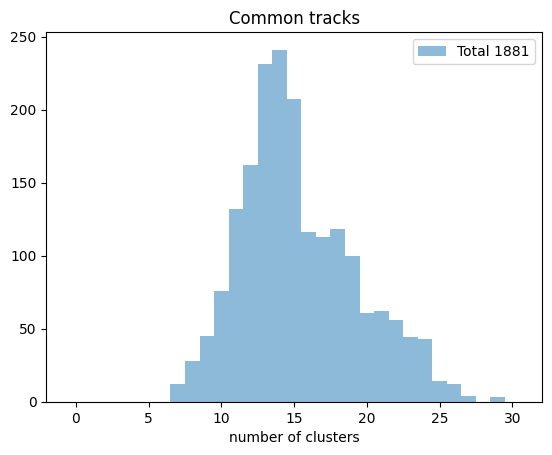

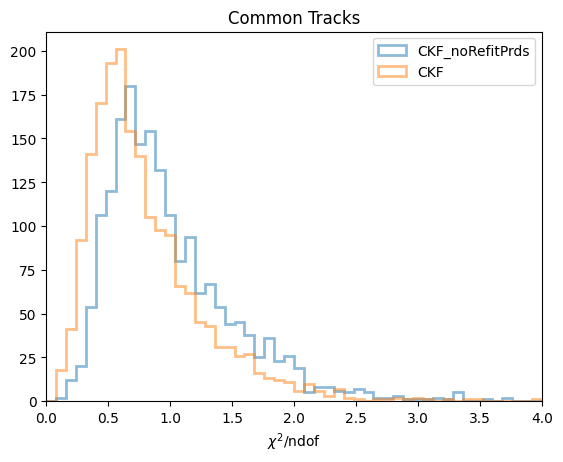

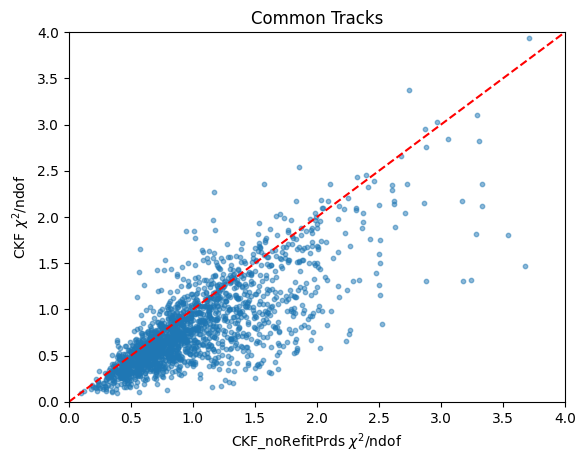

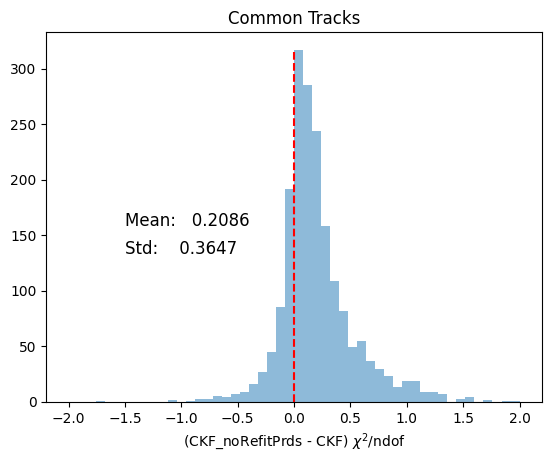

(array([0.60735532, 0.75310216, 0.2773766 , ..., 1.4415333 , 1.89987142,
        2.03387499]),
 array([0.5755    , 0.57952978, 0.20060127, ..., 0.86103667, 1.66608565,
        2.18950009]))

In [ ]:
comparator.plot_common_tracks()

## Impact on GNN Tracks

In [62]:
gnn_withAmbig_base_dir = "/media/DataOcean/projects/tracking/integrateToAthena/run_21.9.26/RunOneEventForDebuging/GNN_noRemoval_withAmbiguityResolvor"
gnn_withAmbig_reader = AthenaRawDataReader(gnn_withAmbig_base_dir, overwrite=False, name="GNN with Ambiguity Resolution")
gnn_withAmbig_reader.read(event_number=event_number)

Total 1 events in directory: /media/DataOcean/projects/tracking/integrateToAthena/run_21.9.26/RunOneEventForDebuging/GNN_noRemoval_withAmbiguityResolvor


### Compare GNN tracks with or without Ambiguity Processor

In [63]:
gnn_compare_ambig = TrackAlgComparator(gnn_reader, gnn_withAmbig_reader)

2012 GNN tracks compared to 1474 GNN with Ambiguity Resolution tracks.
Require min_num_clusters = 5 only for GNN tracks.
Total # of GNN tracks: 2012. After filtering, # of GNN tracks: 1821 (90.507%)
Matched: 1473, 1821, 0.8089
GNN is a subset: 0, 1821, 0.0000
GNN with Ambiguity Resolution is a subset: 1, 1821, 0.0005
Disjoint:  346, 1821, 0.1900


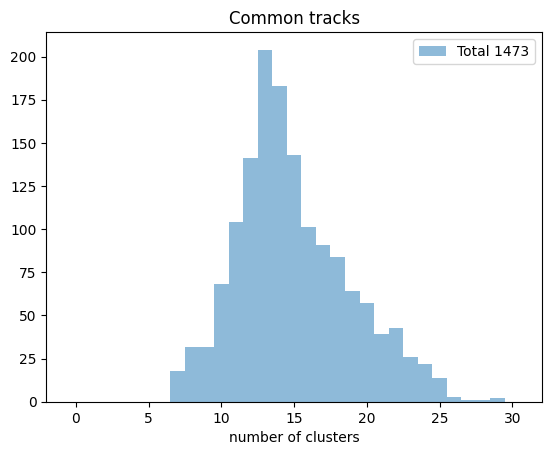

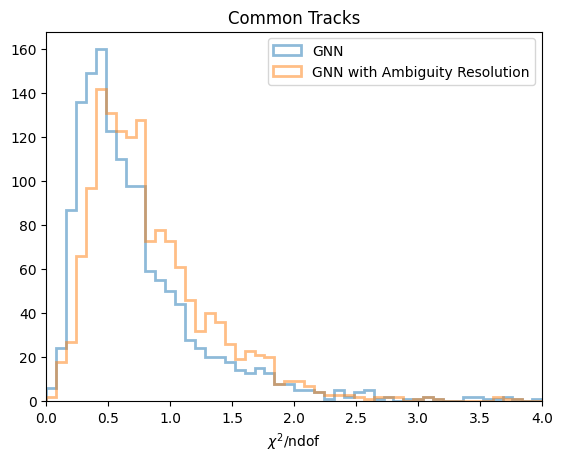

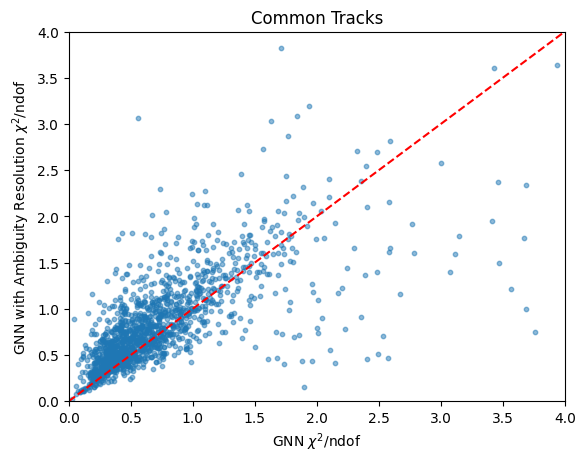

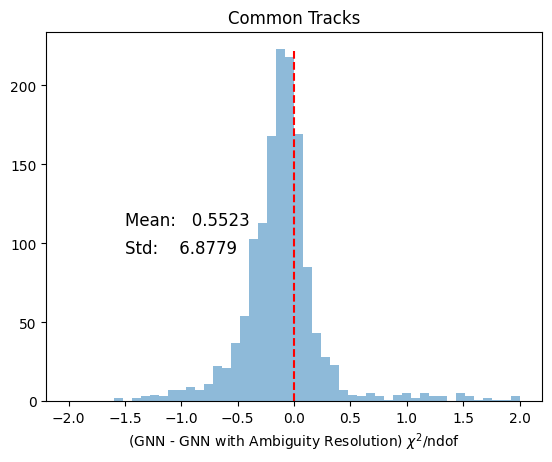

(array([1.0892846 , 0.45825191, 0.63141727, ..., 0.53034782, 0.26666905,
        0.67329048]),
 array([0.82231536, 0.42804573, 0.58699456, ..., 0.66410869, 0.35759619,
        1.0724619 ]))

In [49]:
gnn_compare_ambig.plot_common_tracks()

### Compare GNN with Ambiguity Processor with CKF

In [66]:
gnn_withAmbig_compare_CKF = TrackAlgComparator(gnn_withAmbig_reader, ckf_reader)

### Common Tracks

1474 GNN with Ambiguity Resolution tracks compared to 2077 CKF tracks.
Require min_num_clusters = 5 only for GNN with Ambiguity Resolution tracks.
Total # of GNN with Ambiguity Resolution tracks: 1474. After filtering, # of GNN with Ambiguity Resolution tracks: 1474 (100.000%)
Matched: 771, 1474, 0.5231
GNN with Ambiguity Resolution is a subset: 331, 1474, 0.2246
CKF is a subset: 183, 1474, 0.1242
Disjoint:  53, 1474, 0.0360


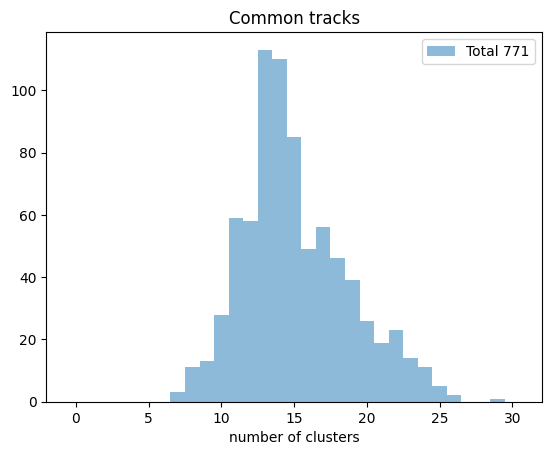

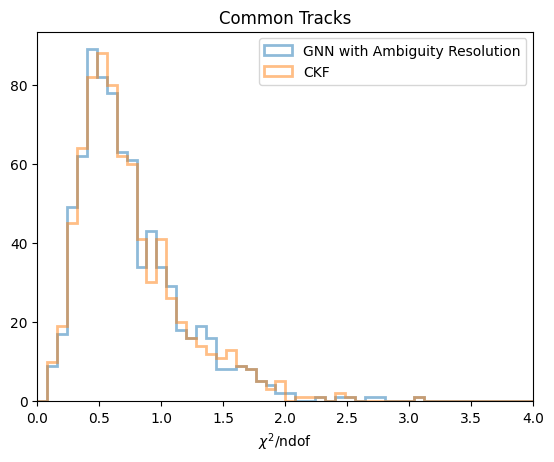

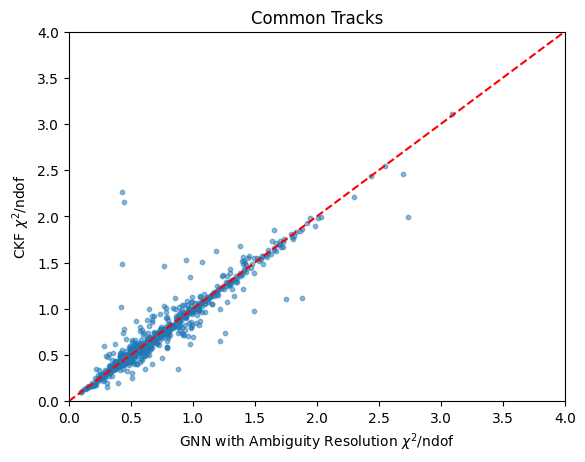

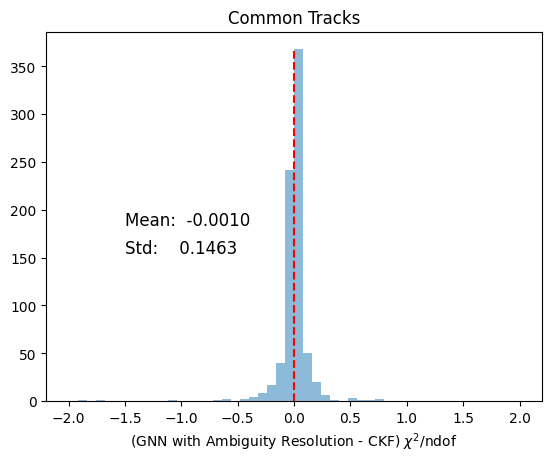

In [58]:
_ = gnn_withAmbig_compare_CKF.plot_common_tracks()

### Disjoint Tracks

In [67]:
_ = gnn_withAmbig_compare_CKF.plot_disjoint_tracks()

NameError: name 'reader' is not defined